In [13]:
import pandas as pd
import numpy as np

In [14]:
import os
print(os.getcwd())

/Users/vega7unk/Documents/4th Sem DSI/ilab project/ilab-group-12-1-fall-detection/notebooks/DL_lpf_jitters


In [15]:
pd.set_option('display.max_columns', None)

X, y = pd.read_pickle("/Users/vega7unk/Documents/4th Sem DSI/ilab project/ilab-group-12-1-fall-detection/data/processed/X_y_normalized_1.pkl")

In [16]:
print("X shape:", X.shape)  # Should be (samples, time_steps, features)
print("y shape:", y.shape)

X shape: (72183, 25, 6)
y shape: (72183,)


In [17]:
y

array(['JOG', 'STN', 'STD', ..., 'LYI', 'STD', 'STD'], dtype='<U3')

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Converts labels to integers

# Optionally, store label mapping
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'BSC': 0, 'CHU': 1, 'CSI': 2, 'CSO': 3, 'FKL': 4, 'FOL': 5, 'JOG': 6, 'JUM': 7, 'LYI': 8, 'SCH': 9, 'SDL': 10, 'SIT': 11, 'STD': 12, 'STN': 13, 'STU': 14, 'WAL': 15}


# CNN

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the input shape (e.g., 25 time steps, 6 channels)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(set(y_encoded))  # Should be 15 based on your labels

model = Sequential([
    # First convolutional block
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    # Second convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # Apply max pooling to reduce sequence length and capture dominant features
    MaxPooling1D(pool_size=2),
    # Third convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # Global average pooling to flatten the tensor for the dense layer
    GlobalAveragePooling1D(),
    # Fully connected (dense) layer with dropout
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output layer: softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

# Compile the model with a common optimizer and loss function for classification
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()


/Users/vega7unk/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 23, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,496 (330.06 KB)

 Trainable params: 84,496 (330.06 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Training the model with validation split
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7229 - loss: 0.9088 - val_accuracy: 0.8723 - val_loss: 0.3683
Epoch 2/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8689 - loss: 0.3745 - val_accuracy: 0.8968 - val_loss: 0.2749
Epoch 3/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8874 - loss: 0.3129 - val_accuracy: 0.9016 - val_loss: 0.2527
Epoch 4/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8983 - loss: 0.2782 - val_accuracy: 0.9043 - val_loss: 0.2403
Epoch 5/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9087 - loss: 0.2559 - val_accuracy: 0.9067 - val_loss: 0.2360
Epoch 6/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9135 - loss: 0.2336 - val_accuracy: 0.9168 - val_loss: 0.2145
Epoch 7/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9172 - loss: 0.2218 - val_accuracy: 0.9189 - val_loss: 0.2037
Epoch 8/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9212 - loss: 0.2062 - 

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):
    """
    Evaluates a deep learning model on test data and generates common evaluation metrics and plots.

    Parameters:
        model: Trained deep learning model (Keras/TensorFlow model).
        X_test (np.array): Test data with shape (num_samples, timesteps, channels).
        y_test (np.array): True labels corresponding to X_test. Assumed to be numeric.
        label_classes (list, optional): List of string label names (e.g., ['BSC', 'CHU', ...]).
                                        If None, numeric labels will be used in plots.
        plot_confusion_matrix (bool): Whether to generate a confusion matrix plot.
        plot_roc (bool): Whether to compute and plot ROC curves and display the ROC-AUC score (for multi-class).

    Returns:
        metrics (dict): A dictionary containing loss, accuracy, precision, recall, f1 score, 
                        and if computed, ROC-AUC score.
    """
    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.2632
Test Accuracy: 0.9480
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


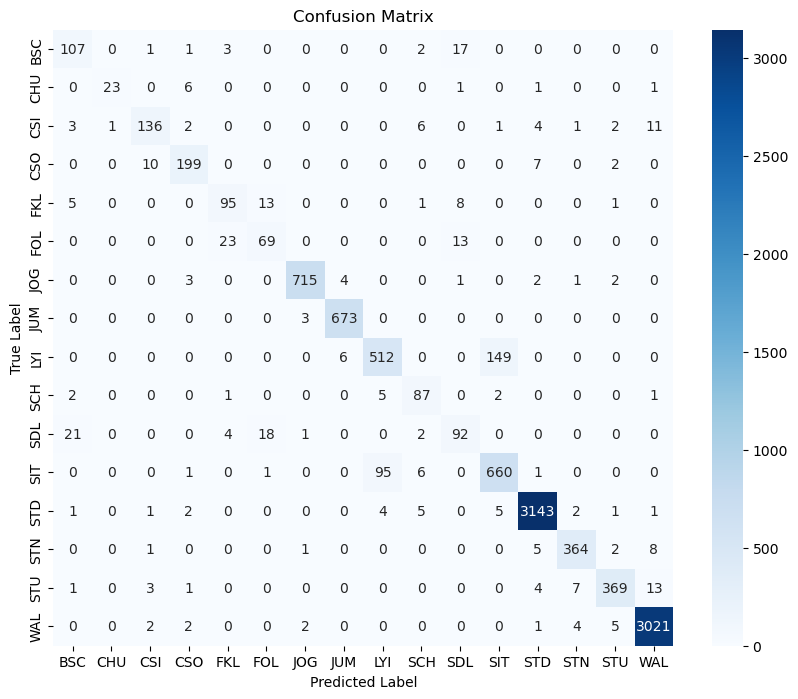

Classification Report:
               precision    recall  f1-score   support

         BSC       0.76      0.82      0.79       131
         CHU       0.96      0.72      0.82        32
         CSI       0.88      0.81      0.85       167
         CSO       0.92      0.91      0.91       218
         FKL       0.75      0.77      0.76       123
         FOL       0.68      0.66      0.67       105
         JOG       0.99      0.98      0.99       728
         JUM       0.99      1.00      0.99       676
         LYI       0.83      0.77      0.80       667
         SCH       0.80      0.89      0.84        98
         SDL       0.70      0.67      0.68       138
         SIT       0.81      0.86      0.83       764
         STD       0.99      0.99      0.99      3165
         STN       0.96      0.96      0.96       381
         STU       0.96      0.93      0.94       398
         WAL       0.99      0.99      0.99      3037

    accuracy                           0.95     10828
  

In [23]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]
metrics = evaluate_model(model, X_test, y_test, label_classes=label_classes)
